# dask.bag and dask.dataframe

The standard imports for `dask.bag` and `dask.dataframe` are `db` and `dd`, respectively.

In [1]:
from distributed import Client
client = Client("127.0.0.1:53731")

In [2]:
import dask.bag as db
import dask.dataframe as dd

The simplest bag example possible:

In [3]:
bag = db.from_sequence([1, 2, 3, 4, 5, 6], npartitions=2)

In [4]:
evens_squared = bag.filter(lambda x: x % 2 == 0).map(lambda x: x ** 2)

In [5]:
evens_squared.compute()

[4, 16, 36]

Let's look at something a bit more interesting, some US Federal Election Commission political campaign contribution data stored in a number of plain text files.

In [6]:
from pathlib import Path
columns = Path("data/fec/columns.csv").read_text().strip().split(",")
columns

['CMTE_ID',
 'AMNDT_IND',
 'RPT_TP',
 'TRANSACTION_PGI',
 'IMAGE_NUM',
 'TRANSACTION_TP',
 'ENTITY_TP',
 'NAME',
 'CITY',
 'STATE',
 'ZIP_CODE',
 'EMPLOYER',
 'OCCUPATION',
 'TRANSACTION_DT',
 'TRANSACTION_AMT',
 'OTHER_ID',
 'TRAN_ID',
 'FILE_NUM',
 'MEMO_CD',
 'MEMO_TEXT',
 'SUB_ID']

In [7]:
!head -n 3 data/fec/contributions/d100.txt

C00649350|N|12G|G2020|202010229332727473|15E|IND|KATZMAN, STEVE|AUSTIN|TX|787235388|NOT EMPLOYED|RETIRED|10042020|25|C00401224|VTR3QW8HJN8|1461945||* EARMARKED CONTRIBUTION: SEE BELOW|4120920201967258537
C00649350|N|12G|G2020|202010229332727474|15E|IND|DICKEY, HELEN|EL CERRITO|CA|945304151|NOT EMPLOYED|RETIRED|10042020|15|C00401224|VTR3QW8HQN8|1461945||* EARMARKED CONTRIBUTION: SEE BELOW|4120920201967258539
C00649350|N|12G|G2020|202010229332724034|15E|IND|ROBINSON, LINDA P|BEAUMONT|TX|777067415|NOT EMPLOYED|RETIRED|10032020|200|C00401224|VTR3QW8BK23|1461945||* EARMARKED CONTRIBUTION: SEE BELOW|4120920201967248221


We'll create a bag by:
- reading the text files (with `read_text`),
- doing a bit of per-line processing (with `map`),
- and limit the dataset to Atlanta, GA (with `filter`).

In [8]:
bag = (db.read_text("data/fec/contributions/*")
         .map(lambda x: {k: v for k, v in zip(columns, x.split("|"))})
         .filter(lambda x: x["STATE"] == "GA" and x["CITY"] == "ATLANTA"))

A look at the most frequent donation:

In [9]:
freqs = bag.map(lambda x: x["TRANSACTION_AMT"]).frequencies(sort=True)

In [10]:
freqs.take(10)

(('25', 5042),
 ('50', 4145),
 ('100', 3964),
 ('10', 2358),
 ('250', 2142),
 ('15', 2036),
 ('5', 1729),
 ('20', 1597),
 ('500', 1057),
 ('35', 615))

We can convert the existing bag to a dataframe so we can take advantage of both the pandas-like API and the pandas-backend performance.

In [11]:
df = bag.to_dataframe(columns=columns)

We can see what the average contribution is in Atlanta:

In [12]:
df.TRANSACTION_AMT.mean()

ValueError: `mean` not supported with object series

Ah, well that didn't work. Let's use our pandas-like API for some help:

In [13]:
ta = dd.to_numeric(df.TRANSACTION_AMT, errors="coerce")

Using `persist` instead of `compute` will force the result of the computation to persist in memory, allowing for more performant repeated use.

In [14]:
ta = ta.persist()

In [15]:
ta = ta[(ta > 0) & (ta < 20000)]
ta.mean().compute()

144.37462531351318

In [16]:
ta[ta > 150].mean().compute()

675.0737267880126

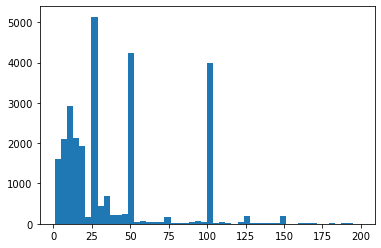

In [17]:
import matplotlib.pyplot as plt
n, bins, pathes = plt.hist(ta[ta < 200].to_dask_array().compute(), bins=50)

In [18]:
ta.value_counts().nlargest(10).compute()

25     5042
50     4145
100    3964
10     2358
250    2142
15     2036
5      1729
20     1597
500    1057
35      615
Name: TRANSACTION_AMT, dtype: int64